In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

from preprocessing import *
from settings import *
from utils import *
from feature_engineering import *
from model import *
from pprint import pprint


from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.sql.types import StringType
from unidecode import unidecode
from pyspark.sql.functions import *


spark = SparkSession.builder.getOrCreate()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Spark UDF

In [3]:
def unaccent_py(text):
    if text is not None:
        return unidecode(text)
    else:
        return None        
_ =spark.udf.register("unaccent_py", unaccent_py, StringType())

def scholar_semester(input_date):
    if input_date is not None:
        return str(input_date.year + list([0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 1.1, 1.1, 1.1])[input_date.month-1])
    else:
        return None
_ = spark.udf.register("scholar_semester", scholar_semester, StringType())

# Ingestion

## INEP

In [128]:
inep_query = """
with canonical_courses as (
  select distinct 
    unaccent_py(lower(canonical_courses.name)) as clean_name
    ,clean_canonical_courses.id as clean_canonical_course_id
    ,clean_canonical_courses.name as clean_canonical_course_name
    ,family.family
  from
    querobolsa_production.canonical_courses
    join querobolsa_production.canonical_courses clean_canonical_courses on canonical_courses.clean_canonical_course_id = clean_canonical_courses.id
    left join inteligencia.family on canonical_courses.clean_canonical_course_id = family.canonical_course_id
),
aluno_2018 as (
  select distinct
  aluno.co_aluno_curso
  ,case when aluno.nu_ano_ingresso = aluno.nu_ano_censo then 1 else 0 end as entered_this_year
  ,case when aluno.nu_ano_ingresso = aluno.nu_ano_censo -1 then 1 else 0 end as entered_last_year
  ,aluno.id_aluno
  ,unaccent_py(lower(curso.no_curso)) as no_curso_clean
  ,curso.no_curso as no_curso
  ,case when aluno.tp_modalidade_ensino = 2 then 3 else aluno.tp_modalidade_ensino end as course_kind
  ,case when curso.co_municipio is NULL then local_oferta.co_municipio else curso.co_municipio end as co_municipio_curso
  ,case when curso.co_uf is NULL then local_oferta.co_uf else curso.co_uf end as co_uf_curso
  ,aluno.co_municipio_nascimento
  ,aluno.co_uf_nascimento
  ,case when aluno.tp_grau_academico = 1 then 'Bacharelado' 
        when aluno.tp_grau_academico = 2 then 'Licenciatura' 
        when aluno.tp_grau_academico = 3 then 'Tecnologico' 
        when aluno.tp_grau_academico = 4 then 'Bachar_Licenc' 
        else 'None' end as tp_grau_academico
  ,case when aluno.tp_cor_raca = 0 then 'Nao_declarado'
        when aluno.tp_cor_raca = 1 then 'Branca'
        when aluno.tp_cor_raca = 2 then 'Preta'
        when aluno.tp_cor_raca = 3 then 'Parda'
        when aluno.tp_cor_raca = 4 then 'Amarela'
        when aluno.tp_cor_raca = 5 then 'Indigena'
        else 'No_info' end as tp_cor_raca  
    ,case when aluno.tp_situacao = 2 then 'Cursando'
        when aluno.tp_situacao = 3 then 'Matricula_trancada'
        when aluno.tp_situacao = 4 then 'Desvinculado_do_curso'
        when aluno.tp_situacao = 5 then 'Transferido_para_outro_curso_da_mesma_IES'
        when aluno.tp_situacao = 6 then 'Formado'
        when aluno.tp_situacao = 7 then 'Falecido' end as tp_situacao
  ,aluno.tp_sexo
  ,aluno.nu_idade
  ,aluno.qt_carga_horaria_total
  ,aluno.qt_carga_horaria_integ
  ,aluno.in_ingresso_enem
  ,aluno.in_ingresso_avaliacao_seriada
  ,aluno.in_ingresso_selecao_simplifica
  ,aluno.in_ingresso_vaga_remanesc
  ,aluno.in_ingresso_vaga_prog_especial
  ,aluno.in_reserva_vagas
  ,aluno.in_financiamento_estudantil
  ,coalesce(aluno.in_fin_reemb_fies,0) as in_fin_reemb_fies
  ,coalesce(aluno.in_fin_reemb_estadual,0) as in_fin_reemb_estadual
  ,coalesce(aluno.in_fin_reemb_municipal,0) as in_fin_reemb_municipal
  ,coalesce(aluno.in_fin_reemb_prog_ies,0) as in_fin_reemb_prog_ies
  ,coalesce(aluno.in_fin_reemb_ent_externa,0) as in_fin_reemb_ent_externa
  ,coalesce(aluno.in_fin_naoreemb_prouni_integr,0) as in_fin_naoreemb_prouni_integr
  ,coalesce(aluno.in_fin_naoreemb_prouni_parcial,0) as in_fin_naoreemb_prouni_parcial
  ,coalesce(aluno.in_fin_naoreemb_estadual,0) as in_fin_naoreemb_estadual
  ,coalesce(aluno.in_fin_naoreemb_municipal,0) as in_fin_naoreemb_municipal
  ,coalesce(aluno.in_fin_naoreemb_prog_ies,0) as in_fin_naoreemb_prog_ies
  ,coalesce(aluno.in_fin_naoreemb_ent_externa,0) as in_fin_naoreemb_ent_externa 
  from 
    dados_publicos.dm_aluno_2018 aluno
    left join dados_publicos.dm_curso_2018 curso on aluno.co_curso = curso.co_curso
    left join dados_publicos.dm_local_oferta_2018 local_oferta on aluno.co_curso_polo = local_oferta.co_curso_polo
  where
    aluno.tp_categoria_administrativa in (4,5,7)
    and aluno.tp_nivel_academico = 1
)
select 
  municipios_curso.name as city_inep
  ,uf_curso.abbreviation as state_inep
  ,cities.name as city
  ,cities.state
  ,canonical_courses.clean_canonical_course_id
  ,canonical_courses.clean_canonical_course_name
  ,case when municipios_curso.id <> municipios_nasc.id then 1 else 0 end as out_of_city 
  ,case when uf_curso.id <> uf_nasc.id then 1 else 0 end as out_of_state 
  ,aluno.*
from 
  aluno_2018 aluno
  left join canonical_courses on aluno.no_curso_clean = canonical_courses.clean_name 
  left join dados_publicos.municipios municipios_curso on aluno.co_municipio_curso = municipios_curso.id
  left join dados_publicos.uf uf_curso on aluno.co_uf_curso = uf_curso.id
  left join dados_publicos.municipios municipios_nasc on aluno.co_municipio_nascimento = municipios_nasc.id
  left join dados_publicos.uf uf_nasc on aluno.co_uf_nascimento = uf_nasc.id  
  left join querobolsa_production.cities cities on cities.state = uf_curso.abbreviation and unaccent_py(lower(cities.name)) = unaccent_py(lower(municipios_curso.name))
"""
sdf_inep_aluno = spark.sql(inep_query)


#One hot encoding categorical cols
convert_cols = ["tp_grau_academico","tp_cor_raca","tp_situacao"]
for convert_col in convert_cols:
    print("OneHotEncoding column:  ", convert_col)
    categories = sdf_inep_aluno.select(convert_col).distinct().rdd.flatMap(lambda x: x).collect()
    categories_expr = [when(col(convert_col) == cat, 1).otherwise(0).alias( convert_col + "_" + cat) for cat in categories]
    sdf_inep_aluno = sdf_inep_aluno.select("*", *categories_expr)
print("Number of rows (aluno-curso) from inep (graduacao) : ", sdf_inep_aluno.count() )


OneHotEncoding column:   tp_grau_academico
OneHotEncoding column:   tp_cor_raca
OneHotEncoding column:   tp_situacao


In [129]:
df_inep_aluno = sdf_inep_aluno.groupby(list_remove(REDUCED_TARGET_COLS,'family')).agg({
  'id_aluno':'count',
  'entered_this_year': 'sum',
  'entered_last_year': 'sum',
  'tp_situacao_Cursando':'sum',
  'tp_situacao_Matricula_trancada':'sum',
  'tp_situacao_Desvinculado_do_curso':'sum',
  'tp_situacao_Transferido_para_outro_curso_da_mesma_IES':'sum',
  'tp_situacao_Formado':'sum',
  'tp_situacao_Falecido':'sum',  
  'out_of_city':'mean',
  'out_of_state':'mean',
  'tp_grau_academico_Bacharelado':'mean',
  'tp_grau_academico_Licenciatura':'mean',
  'tp_grau_academico_Tecnologico':'mean',
  'tp_grau_academico_None':'mean',
  'tp_cor_raca_Nao_declarado':'mean',
  'tp_cor_raca_Branca':'mean',
  'tp_cor_raca_Preta':'mean',
  'tp_cor_raca_Parda':'mean',
  'tp_cor_raca_Amarela':'mean',
  'tp_cor_raca_Indigena':'mean',
  'tp_cor_raca_No_info':'mean',
  'tp_sexo':'mean',
  'nu_idade':'mean',
  'qt_carga_horaria_total':'mean',  
  'qt_carga_horaria_integ':'mean',  
  'in_ingresso_enem':'mean',  
  'in_ingresso_avaliacao_seriada':'mean',  
  'in_ingresso_selecao_simplifica':'mean',  
  'in_ingresso_vaga_remanesc':'mean',  
  'in_ingresso_vaga_prog_especial':'mean',  
  'in_reserva_vagas':'mean',  
  'in_financiamento_estudantil':'mean',  
  'in_fin_reemb_fies':'mean',  
  'in_fin_reemb_estadual':'mean',  
  'in_fin_reemb_municipal':'mean',  
  'in_fin_reemb_prog_ies':'mean',  
  'in_fin_reemb_ent_externa':'mean',  
  'in_fin_naoreemb_prouni_integr':'mean',  
  'in_fin_naoreemb_prouni_parcial':'mean',  
  'in_fin_naoreemb_estadual':'mean',  
  'in_fin_naoreemb_municipal':'mean',  
  'in_fin_naoreemb_prog_ies':'mean',  
  'in_fin_naoreemb_ent_externa':'mean'  
}).orderBy('count(id_aluno)',ascending=False).toPandas()
print("Number of targets from dm_aluno: ", df_inep_aluno.shape[0])

print("Warning!! Loosing ",\
      100 - 100*df_inep_aluno.dropna(subset= list_remove(REDUCED_TARGET_COLS,'family'))['count(id_aluno)'].sum()/df_inep_aluno['count(id_aluno)'].sum(),\
      "% of rows due to missing aggregating info - city/course/kind"
)
df_inep_aluno  = df_inep_aluno.dropna(subset= list_remove(REDUCED_TARGET_COLS,'family'))
df_inep_aluno['course_kind'] = df_inep_aluno['course_kind'].astype(float)
df_inep_aluno['clean_canonical_course_id'] = df_inep_aluno['clean_canonical_course_id'].astype(int)


/Users/renatosanabria/anaconda3/envs/demand_estimation/lib/python3.5/site-packages/pyspark/sql/dataframe.py:2152: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 0.8.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


Number of targets from dm_aluno:  66679
Warning!! Loosing  0.13655174645084855 % of rows due to missing aggregating info - city/course/kind


## search_behaviors

### Spark

In [5]:
%%time

REDUCED_SEMESTERS = "('2018.2','2019.1','2019.2')"
search_query = """
with searches as (
  select distinct
    id,
    created_at,
    global_user_id
  from 
    gambit_production.search_behaviors 
  where 
    origin = 2 
    and ref = 'home' 
    and system_id = 2 
    and scholar_semester(created_at) in {}
),
first_search as (
  select 
      min(sb.created_at) first_search_at,
      cast(sb.created_at as date) day,
      sb.global_user_id
  from 
      searches sb
  group by
      2,3
)
select distinct
  sb.id,
  sb.global_user_id,
  cities.name as city,
  cities.state as state,
  sb.search_term,
  sb.canonical_course_id,
  clean_cc.id as clean_canonical_course_id,
  clean_cc.name as clean_canonical_course_name,
  family.family,
  sb.kinds,
  sb.levels,
  cast(sb.created_at as date) day,
  sb.maximum_value,
  sb.num_pages,
  sb.current_page,
  size(sb.offer_uuids) as n_offers
from 
  gambit_production.search_behaviors sb
  join first_search on first_search.global_user_id = sb.global_user_id 
  left join querobolsa_production.cities on cities.id = sb.city_id
  left join querobolsa_production.canonical_courses on sb.canonical_course_id = canonical_courses.id
  left join inteligencia.family on family.canonical_course_id = canonical_courses.clean_canonical_course_id
  left join (select * from querobolsa_production.canonical_courses where canonical_courses.dirty=False) clean_cc on clean_cc.id = canonical_courses.clean_canonical_course_id
  
where
  first_search.first_search_at = sb.created_at
  and sb.origin = 2 
  and sb.ref = 'home' 
  and sb.system_id = 2 
  and sb.current_page = 1
  and scholar_semester(sb.created_at) in {}
  and sb.maximum_value is not null
  and sb.levels[0] = 1
""".format(REDUCED_SEMESTERS,REDUCED_SEMESTERS)
sdf_search = spark.sql(search_query)


# df_search = sdf_search.toPandas()
# df_search.head()

CPU times: user 3.97 ms, sys: 3.22 ms, total: 7.19 ms
Wall time: 33.4 s


In [6]:
display(sdf_search.head(50))

[Row(id=8085749, global_user_id=47541622, city='Cuiabá', state='MT', search_term='Enfermagem', canonical_course_id=140, clean_canonical_course_id=140, clean_canonical_course_name='Enfermagem', family='Esporte, Estética e Saúde', kinds=None, levels=[1], day=datetime.date(2018, 6, 8), maximum_value=10000, num_pages=1, current_page=1, n_offers=3),
 Row(id=8383610, global_user_id=39876334, city='Teresina', state='PI', search_term='Farmácia', canonical_course_id=214, clean_canonical_course_id=214, clean_canonical_course_name='Farmácia', family='Esporte, Estética e Saúde', kinds=None, levels=[1], day=datetime.date(2018, 6, 10), maximum_value=10000, num_pages=1, current_page=1, n_offers=5),
 Row(id=8816289, global_user_id=47953611, city='São Paulo', state='SP', search_term='Redes de Computadores', canonical_course_id=358, clean_canonical_course_id=358, clean_canonical_course_name='Redes de Computadores', family='Engenharia e tecnologia', kinds=[1, 8], levels=[1], day=datetime.date(2018, 6, 12

### HDF

In [31]:
search_files = [
    'searches_2018_02_01.h5',
    'searches_2018_02_02.h5',
    'searches_2019_01_01.h5',
    'searches_2019_01_02.h5',
    'searches_2019_01_03.h5',
    'searches_2019_01_04.h5',
]
df_search = pd.DataFrame()
i =0 
for search_file in search_files:
    print("File ",i, "/",len(search_files))
    i+=1
    df_search = pd.concat([
        df_search,
        pd.read_hdf(DATA_FOLDER + search_file, key='df')
    ])
    

df_search = df_search.reset_index()

#Unicode -> str
unicode_cols = ['kinds','city','state','search_term','clean_canonical_course_name','family']
for col in unicode_cols:
    df_search[col] = df_search[col].astype(str)
    df_search[col] = df_search[col].replace('None',np.nan)

df_search['course_kind'] = df_search['kinds'].apply(lambda x: np.nan if pd.isna(x) else( 1 if ('1' in x)&('3' not in x) else (3 if ('1' not in x)&('3' in x) else np.nan)))

print(df_search.shape[0])
df_search.head()

File  0 / 6
File  1 / 6
File  2 / 6
File  3 / 6
File  4 / 6
File  5 / 6
11635776


index       id  global_user_id          city state  \
0      0  7831053        47407213     São Paulo    SP   
1      1  7863668        44501748        Maceió    AL   
2      2  8463676        46432335  Porto Alegre    RS   
3      3  8509758        47798133   Santo André    SP   
4      4  8590636        10139413     Itaperuna    RJ   

               search_term  canonical_course_id  clean_canonical_course_id  \
0     Medicina Veterinária                265.0                      265.0   
1           Jogos Digitais                253.0                      253.0   
2        Educação Especial               1175.0                     1175.0   
3  Relações Internacionais                360.0                      360.0   
4            Administração                  2.0                        2.0   

  clean_canonical_course_name                          family kinds  \
0        Medicina Veterinária       Esporte, Estética e Saúde   NaN   
1              Jogos Digitais         Engenharia e tecnologia   NaN   
2           Educação Especial                        Educação   NaN   
3     Relações Internacionais  Comunicação e Ciências Sociais   NaN   
4               Administração               Gestão e Negócios   NaN   

          day  maximum_value  num_pages  current_page  n_offers  course_kind  
0  2018-06-07          10000          1             1         3          NaN  
1  2018-06-07          10000          1             1         1          NaN  
2  2018-06-11           3000          1             1         8          NaN  
3  2018-06-11          10000          3             1        10          NaN  
4  2018-06-11          10000          4             1        10          NaN

## sales

### Spark

In [7]:
sales_query = """
select distinct
  sales.payment_id,
  sales.campus_city as city,
  sales.campus_state as state,
  canonical_courses.clean_canonical_course_id,
  clean_cc.name as clean_canonical_course_name,
  family.family,
  sales.course_id,
  kinds.parent_id as course_kind,
  levels.parent_id as course_level,
  scholar_semester(payment_date) as scholar_semester,
  sales.coupon_price,
  offers.offered_price,
  offers.id as offer_id,
  offers.start,
  offers.end,
  sales.total_revenue

from 
  data_warehouse.sales
  left join querobolsa_production.coupons on coupons.id = sales.coupon_id
  left join querobolsa_production.offers on offers.id = coupons.offer_id
  left join querobolsa_production.university_offers  on university_offers.id = offers.university_offer_id
  
  left join querobolsa_production.courses on sales.course_id = courses.id
  left join querobolsa_production.canonical_courses on courses.canonical_course_id = canonical_courses.id
  left join inteligencia.family on family.canonical_course_id = canonical_courses.clean_canonical_course_id
  join (select * from querobolsa_production.canonical_courses where canonical_courses.dirty=False) clean_cc on clean_cc.id = canonical_courses.clean_canonical_course_id
  left join (select * from querobolsa_production.kinds where parent_id is not null) kinds on kinds.name = sales.course_kind
  left join (select * from querobolsa_production.levels where parent_id is not null) levels on levels.name = sales.course_level
    
where
  university_offers.enrollment_semester in ('2018.2','2019.1','2019.2')
  and levels.parent_id = 1
"""
df_sales = spark.sql(sales_query).toPandas()

print("Total #rows for SEMESTERS ", SEMESTERS, "  : ", df_sales.shape[0])
print("Total revenue: ", df_sales['total_revenue'].sum())
aux = df_sales['total_revenue'].sum()
print("\nWarning! Considering course_kind = Presencial | EaD")
df_sales = df_sales[df_sales['course_kind'].isin(TARGET_KINDS)]
print("%of revenue being lost: ", 100*(aux - df_sales['total_revenue'].sum())/aux, '%')
print("Net revenue being analysed: ",df_sales['total_revenue'].sum())

df_sales.head()

Total #rows for SEMESTERS  ('2018.2','2019.1','2019.2')   :  267239
Total revenue:  125561533.27999999

Warning! Considering course_kind = Presencial | EaD
%of revenue being lost:  10.0439277385033 %
Net revenue being analysed:  112950223.61000001


payment_id            city state  clean_canonical_course_id  \
0     1401490  Rio de Janeiro    RJ                         34   
1     1928764         Vitória    ES                        121   
2     1947287           Serra    ES                        257   
3     1426152        Salvador    BA                        255   
5     1400352  Rio de Janeiro    RJ                         82   

  clean_canonical_course_name                               family  course_id  \
0                 Biomedicina  Biologia, Agricultura e Veterinária     651481   
1             Educação Física            Esporte, Estética e Saúde      84739   
2                   Logística                    Gestão e Negócios     470160   
3                      Letras                             Educação    1100366   
5              Design Gráfico       Comunicação e Ciências Sociais    3381022   

   course_kind  course_level scholar_semester             coupon_price  \
0            1             1           2018.2   319.680000000000000000   
1            1             1           2019.1   599.930000000000000000   
2            3             1           2019.1   162.840000000000000000   
3            3             1           2018.2   206.920000000000000000   
5            1             1           2018.2  1002.900000000000000000   

  offered_price  offer_id      start                        end  total_revenue  
0        679.32   9766237 2018-07-10 2018-08-06 15:01:12.649397         319.68  
1        599.93  15606239 2019-01-24 2019-02-11 14:57:37.031179         599.93  
2        162.84  15274489 2019-01-21 2019-02-21 12:48:02.753127         162.84  
3        222.00  14774725 2019-01-17 2019-03-12 15:43:24.527844         206.92  
5        501.45   9532617 2018-06-21 2018-07-12 17:43:06.213634        1002.90

In [ ]:
df_sales.info()

### HDF

In [32]:
df_sales = pd.read_hdf(DATA_FOLDER + 'sales.h5', key='df').drop(['start','end'],axis=1)
print("Total #rows for SEMESTERS ", SEMESTERS, "  : ", df_sales.shape[0])
print("Total revenue: ", df_sales['total_revenue'].sum())
aux = df_sales['total_revenue'].sum()
print("\nWarning! Considering course_kind = Presencial | EaD")
df_sales = df_sales[df_sales['course_kind'].isin(TARGET_KINDS)]
print("%of revenue being lost: ", 100*(aux - df_sales['total_revenue'].sum())/aux, '%')
print("Net revenue being analysed: ",df_sales['total_revenue'].sum())

df_sales.head()

Total #rows for SEMESTERS  ('2018.2','2019.1','2019.2')   :  317500
Total revenue:  134607280.79999995

Warning! Considering course_kind = Presencial | EaD
%of revenue being lost:  9.44991505244043 %
Net revenue being analysed:  121887007.11


payment_id       city state  clean_canonical_course_id  \
0     2307044  São Paulo    SP                         82   
1     2256089  São Paulo    SP                         82   
2     2265886  São Paulo    SP                         82   
3     2263352  São Paulo    SP                         82   
4     1382601  São Paulo    SP                         82   

  clean_canonical_course_name                          family  course_id  \
0              Design Gráfico  Comunicação e Ciências Sociais        148   
1              Design Gráfico  Comunicação e Ciências Sociais        148   
2              Design Gráfico  Comunicação e Ciências Sociais        148   
3              Design Gráfico  Comunicação e Ciências Sociais        148   
4              Design Gráfico  Comunicação e Ciências Sociais        148   

   course_kind  coupon_price  offered_price  offer_id  total_revenue  
0            1         86.56         373.11  21341041         273.11  
1            1        186.56         373.11  17719244         373.11  
2            1        186.56         373.11  17719244         373.11  
3            1        186.56         373.11  17719244         373.11  
4            1        337.12         224.75   8644715         337.12

# Formatting

## df_price_range

In [33]:
df_price_range = get_price_range(df_search)
df_price_range.head()

Grouping prices according to:  ['city', 'state', 'clean_canonical_course_id', 'clean_canonical_course_name', 'course_kind', 'family']
% of targets filled:  9.855930727313444 

Grouping prices according to:  ['city', 'state', 'course_kind', 'family']
% of targets filled:  49.78476697603822 

Grouping prices according to:  ['city', 'state', 'course_kind']
% of targets filled:  84.74292302205413 

Grouping prices according to:  ['state', 'course_kind']
% of targets filled:  100.0 

# of target ids from df_search_price:  120567
# of targets with price_range non-null 120567


city state  clean_canonical_course_id  \
0  Porto Nacional    TO                        266   
1         Caçador    SC                        266   
2        Goiatuba    GO                        266   
3         Joaçaba    SC                        266   
4         Palhoça    SC                        266   

  clean_canonical_course_name  course_kind                     family  \
0                    Medicina          1.0  Esporte, Estética e Saúde   
1                    Medicina          1.0  Esporte, Estética e Saúde   
2                    Medicina          1.0  Esporte, Estética e Saúde   
3                    Medicina          1.0  Esporte, Estética e Saúde   
4                    Medicina          1.0  Esporte, Estética e Saúde   

   price_low  price_high  
0     1590.0      4000.0  
1     1470.0      3150.0  
2     1200.0      2450.0  
3     1130.0      2500.0  
4     1120.0      3000.0

## df_spine_search

In [34]:
df_spine_search = df_search[REDUCED_TARGET_COLS + ['maximum_value','id','num_pages','n_offers']].dropna()
df_spine_search['clean_canonical_course_id'] = df_spine_search['clean_canonical_course_id'].astype(int)

df_spine_search = binerize_price(df_spine_search,df_price_range)
print("#of rows from df_search with target fully filled: ", df_spine_search.shape[0])


df_spine_search = df_spine_search.groupby(TARGET_COLS + ['price_low','price_high'])['num_pages','id','n_offers']\
                                 .agg({'id':'count','num_pages':'mean','n_offers':'mean'})\
                                 .reset_index()\
                                 .rename(columns={'num_pages':'n_av_pages','id':'n_searches','n_offers':'n_av_offers'})\
                                 .sort_values('n_searches',ascending=False)
print("#target_id in df_spine_search: ", df_spine_search.shape[0])

df_spine_search.head(10)

Warning!!  0.9281011797847387  % of rows with missing price range
Warning!! Filling NA with overall average
#of rows from df_search with target fully filled:  3807559
#target_id in df_spine_search:  245721


city state  clean_canonical_course_id  \
219815  São Paulo    SP                        115   
219612  São Paulo    SP                          2   
219838  São Paulo    SP                        140   
220357  São Paulo    SP                        341   
220560  São Paulo    SP                        869   
219749  São Paulo    SP                         48   
219813  São Paulo    SP                        115   
219836  São Paulo    SP                        140   
219610  São Paulo    SP                          2   
219814  São Paulo    SP                        115   

       clean_canonical_course_name  course_kind price_range  price_low  \
219815                     Direito          1.0     premium      450.0   
219612               Administração          1.0     premium      300.0   
219838                  Enfermagem          1.0     premium      350.0   
220357                  Psicologia          1.0     premium      400.0   
220560                   Pedagogia          1.0     premium      250.0   
219749          Ciências Contábeis          1.0     premium      350.0   
219813                     Direito          1.0      medium      450.0   
219836                  Enfermagem          1.0      medium      350.0   
219610               Administração          1.0      medium      300.0   
219814                     Direito          1.0     popular      450.0   

        price_high  n_searches  n_av_pages  n_av_offers  
219815       700.0       25334    5.563867     8.470830  
219612       500.0       21715    9.556113     8.451531  
219838       550.0       20830    4.589390     8.496399  
220357       650.0       20059    3.755970     8.614188  
220560       400.0       13416    8.726968     8.295468  
219749       550.0       13039    7.770995     8.552803  
219813       700.0       12626    3.251228     8.237209  
219836       550.0       11764    2.048113     7.293608  
219610       500.0       11725    7.203923     8.516077  
219814       700.0       11661    0.987994     4.084041

In [35]:
#Opportunities: high n_searches, low n_av_pages 
df_spine_search[df_spine_search['n_av_pages'].round()==0].head(10)

city state  clean_canonical_course_id  \
220356       São Paulo    SP                        341   
186632  Rio de Janeiro    RJ                        140   
187121  Rio de Janeiro    RJ                        341   
220322       São Paulo    SP                        291   
129473          Manaus    AM                        140   
24555   Belo Horizonte    MG                        115   
129452          Manaus    AM                        115   
32123         Brasília    DF                        115   
220323       São Paulo    SP                        291   
78444        Fortaleza    CE                        115   

       clean_canonical_course_name  course_kind price_range  price_low  \
220356                  Psicologia          1.0     popular      400.0   
186632                  Enfermagem          1.0     popular      400.0   
187121                  Psicologia          1.0     popular      500.0   
220322                 Odontologia          1.0      medium      600.0   
129473                  Enfermagem          1.0     popular      300.0   
24555                      Direito          1.0     popular      500.0   
129452                     Direito          1.0     popular      500.0   
32123                      Direito          1.0     popular      550.0   
220323                 Odontologia          1.0     popular      600.0   
78444                      Direito          1.0     popular      500.0   

        price_high  n_searches  n_av_pages  n_av_offers  
220356       650.0        7918    0.323440     0.841500  
186632       650.0        3566    0.337353     1.119181  
187121       800.0        3157    0.184035     0.452645  
220322      1000.0        2863    0.472930     1.346140  
129473       500.0        2695    0.210019     0.496104  
24555        800.0        2363    0.138807     0.417689  
129452       800.0        2249    0.108493     0.341930  
32123        900.0        2191    0.183934     0.475126  
220323      1000.0        2135    0.051522     0.070726  
78444        750.0        2057    0.187652     0.488576

## df_spine_interest

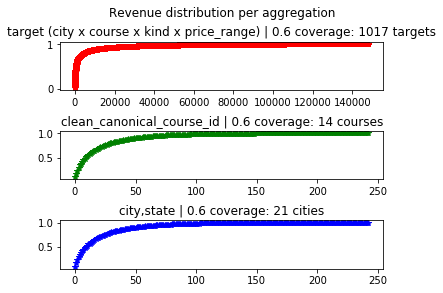

In [36]:
#Getting top cities and top courses 

df_agg_target, top_target = aggregate_searches(df_search,REDUCED_TARGET_COLS,PERC_REVENUE_THRESHOLD)
df_agg_city, top_cities = aggregate_searches(df_search,['city','state'],PERC_REVENUE_THRESHOLD)
df_agg_course, top_courses = aggregate_searches(df_search,['clean_canonical_course_id','clean_canonical_course_name'],PERC_REVENUE_THRESHOLD)

fig,ax = plt.subplots(3,constrained_layout=True)
fig.suptitle("Revenue distribution per aggregation")

ax[0].plot(df_agg_target['index'],df_agg_target['cum_perc_search'],'r*')
ax[0].set_title('target (city x course x kind x price_range) | ' +str(PERC_REVENUE_THRESHOLD) + ' coverage: ' + str(top_target.shape[0]) + ' targets')

ax[1].plot(df_agg_course['index'],df_agg_course['cum_perc_search'],'g*')
ax[1].set_title('clean_canonical_course_id | ' + str(PERC_REVENUE_THRESHOLD) + ' coverage: ' + str(top_courses.shape[0]) + ' courses')

ax[2].plot(df_agg_course['index'],df_agg_course['cum_perc_search'],'b*')
ax[2].set_title('city,state | ' + str(PERC_REVENUE_THRESHOLD) + ' coverage: ' + str(top_cities.shape[0]) + ' cities')

display()

In [37]:
print("Top cities / courses: ")
print(top_cities)
print("\n")
print(top_courses)

Top cities / courses: 
                   city state  rank
0             São Paulo    SP     1
1        Rio de Janeiro    RJ     2
2              Brasília    DF     3
3        Belo Horizonte    MG     4
4              Curitiba    PR     5
5             Fortaleza    CE     6
6                Manaus    AM     7
7              Salvador    BA     8
8                Recife    PE     9
9               Goiânia    GO    10
10  São José dos Campos    SP    11
11                Belém    PA    12
12             Campinas    SP    13
13             São Luís    MA    14
14                Natal    RN    15
15             Teresina    PI    16
16          João Pessoa    PB    17
17               Maceió    AL    18
18         Porto Alegre    RS    19
19             Sorocaba    SP    20
20               Santos    SP    21


    clean_canonical_course_id clean_canonical_course_name  rank
0                         115                     Direito     1
1                         140                  Enfermag

In [38]:
df_spine_interest = cross_join(top_cities.drop('rank',axis=1),top_courses.drop('rank',axis=1))
df_spine_interest = cross_join(df_spine_interest,pd.DataFrame({'course_kind':TARGET_KINDS}))
df_spine_interest = cross_join(df_spine_interest,pd.DataFrame({'price_range':PRICE_RANGE}))
print("Number of targets of interest: ", df_spine_interest.shape[0])
df_spine_interest['interest'] = 1
df_spine_interest.head()

Number of targets of interest:  1764


city state  clean_canonical_course_id clean_canonical_course_name  \
0  São Paulo    SP                        115                     Direito   
1  São Paulo    SP                        115                     Direito   
2  São Paulo    SP                        115                     Direito   
3  São Paulo    SP                        115                     Direito   
4  São Paulo    SP                        115                     Direito   

   course_kind price_range  interest  
0            1     popular         1  
1            1      medium         1  
2            1     premium         1  
3            3     popular         1  
4            3      medium         1

## df_spine_sales

In [39]:
print("\nBinerizing offered_price...")
df_sales = binerize_price(df_sales,df_price_range,price_col='total_revenue')

#Aggregating sales per target (except price_range)
df_spine_sales = df_sales.groupby(TARGET_COLS).agg({
  'payment_id':'count',
  'total_revenue':'sum'
}).reset_index().sort_values('total_revenue',ascending=False).rename(columns={'payment_id':'#payments'})
df_spine_sales['cum_perc_revenue'] = (df_spine_sales['total_revenue'].cumsum())/df_spine_sales['total_revenue'].sum()
df_spine_sales = df_spine_sales.reset_index(drop=True)
print("# of targets in df_spine_sales" , df_spine_sales.shape[0])

df_spine_sales.head(10)


Binerizing offered_price...
Warning!!  7.543211917488657  % of rows with missing price range
Warning!! Filling NA with overall average
# of targets in df_spine_sales 37239


city state  clean_canonical_course_id  \
0       São Paulo    SP                        115   
1       São Paulo    SP                          2   
2       São Paulo    SP                        140   
3       São Paulo    SP                        341   
4  Rio de Janeiro    RJ                        115   
5       São Paulo    SP                        869   
6       São Paulo    SP                         48   
7       São Paulo    SP                        217   
8       São Paulo    SP                        115   
9       São Paulo    SP                        214   

  clean_canonical_course_name  course_kind price_range  total_revenue  \
0                     Direito            1     premium      824283.89   
1               Administração            1     premium      754894.62   
2                  Enfermagem            1     premium      714056.68   
3                  Psicologia            1     premium      689849.20   
4                     Direito            1     premium      537516.26   
5                   Pedagogia            1     premium      513682.97   
6          Ciências Contábeis            1     premium      510936.96   
7                Fisioterapia            1     premium      486611.08   
8                     Direito            1      medium      482207.07   
9                    Farmácia            1     premium      443359.87   

   #payments  cum_perc_revenue  
0        874          0.006763  
1       1040          0.012956  
2        853          0.018814  
3        678          0.024474  
4        523          0.028884  
5        881          0.033099  
6        648          0.037290  
7        528          0.041283  
8        828          0.045239  
9        499          0.048876

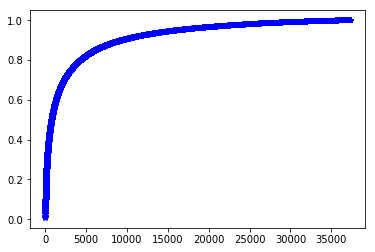

In [40]:
fig,ax = plt.subplots()
ax.plot(df_spine_sales.reset_index(drop=False)['index'],df_spine_sales['cum_perc_revenue'],'b*')

## df_spine ( Final )

In [41]:
df_spine = pd.merge(
  df_spine_search,
  df_spine_sales.drop('cum_perc_revenue',axis=1),
  on=TARGET_COLS,
  how='outer'
)

df_spine = pd.merge(
  df_spine,
  df_spine_interest,
  on=TARGET_COLS,
  how='outer'
)

# df_spine['#offers'] = df_spine['#offers'].fillna(0)
df_spine['total_revenue'] = df_spine['total_revenue'].fillna(0)
df_spine['#payments'] = df_spine['#payments'].fillna(0)
df_spine['interest'] = df_spine['interest'].fillna(0)
df_spine['n_av_pages'] = df_spine['n_av_pages'].fillna(0)
df_spine['n_av_offers'] = df_spine['n_av_offers'].fillna(0)

df_spine = df_spine.sort_values(['interest','total_revenue'],ascending=False)

print("% of revenue in targets with no searches: " , 100*df_spine[pd.isna(df_spine['n_searches'])]['total_revenue'].sum()/df_sales['total_revenue'].sum(), " %")
print("% targets of intereset with no searches: " , 100*df_spine[pd.isna(df_spine['n_searches'])]['interest'].sum()/df_spine_interest.shape[0], " %")
df_spine['n_searches'] = df_spine['n_searches'].fillna(0)
df_spine['price_low'] = df_spine['price_low'].mean()
df_spine['price_high'] = df_spine['price_high'].mean()

df_spine.head()

% of revenue in targets with no searches:  3.9489088985967116  %
% targets of intereset with no searches:  0.6235827664399093  %


city state  clean_canonical_course_id  \
0        São Paulo    SP                        115   
1        São Paulo    SP                          2   
2        São Paulo    SP                        140   
3        São Paulo    SP                        341   
10  Rio de Janeiro    RJ                        115   

   clean_canonical_course_name  course_kind price_range   price_low  \
0                      Direito          1.0     premium  254.528111   
1                Administração          1.0     premium  254.528111   
2                   Enfermagem          1.0     premium  254.528111   
3                   Psicologia          1.0     premium  254.528111   
10                     Direito          1.0     premium  254.528111   

    price_high  n_searches  n_av_pages  n_av_offers  total_revenue  #payments  \
0   468.976288     25334.0    5.563867     8.470830      824283.89      874.0   
1   468.976288     21715.0    9.556113     8.451531      754894.62     1040.0   
2   468.976288     20830.0    4.589390     8.496399      714056.68      853.0   
3   468.976288     20059.0    3.755970     8.614188      689849.20      678.0   
10  468.976288     11519.0    4.898429     8.648494      537516.26      523.0   

    interest  
0        1.0  
1        1.0  
2        1.0  
3        1.0  
10       1.0

In [42]:
n_opportunities = df_spine[ (df_spine['n_av_pages'].round()==0) | (df_spine['n_av_offers'].round()==0)].sort_values('n_searches',ascending=False)['interest'].sum()
print("Number of opportunities (targets of interest with no offers at the time)", n_opportunities)


Number of opportunities (targets of interest with no offers at the time) 393.0


# Feature Engineering

## Searches

In [43]:
df_spine = aggregate_search_groups(df_search,df_spine)
df_spine.head()

city state  clean_canonical_course_id  \
0       São Paulo    SP                        115   
1       São Paulo    SP                          2   
2       São Paulo    SP                        140   
3       São Paulo    SP                        341   
4  Rio de Janeiro    RJ                        115   

  clean_canonical_course_name  course_kind price_range   price_low  \
0                     Direito          1.0     premium  254.528111   
1               Administração          1.0     premium  254.528111   
2                  Enfermagem          1.0     premium  254.528111   
3                  Psicologia          1.0     premium  254.528111   
4                     Direito          1.0     premium  254.528111   

   price_high  n_searches  n_av_pages  n_av_offers  total_revenue  #payments  \
0  468.976288     25334.0    5.563867     8.470830      824283.89      874.0   
1  468.976288     21715.0    9.556113     8.451531      754894.62     1040.0   
2  468.976288     20830.0    4.589390     8.496399      714056.68      853.0   
3  468.976288     20059.0    3.755970     8.614188      689849.20      678.0   
4  468.976288     11519.0    4.898429     8.648494      537516.26      523.0   

   interest  search_city_kind  search_city  search_state  search_course  
0       1.0          795771.0    1757393.0     3275570.0         818677  
1       1.0          795771.0    1757393.0     3275570.0         563195  
2       1.0          795771.0    1757393.0     3275570.0         667435  
3       1.0          795771.0    1757393.0     3275570.0         486145  
4       1.0          263934.0     738568.0     1086548.0         818677

## INEP

In [ ]:
"""
TODO:
    - delta entered this year - entered last year
    - add dataframe from courses
"""

In [61]:
df_inep_aluno.head()

'1'

In [63]:
df_spine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252630 entries, 0 to 252629
Data columns (total 18 columns):
city                           252630 non-null object
state                          252630 non-null object
clean_canonical_course_id      252630 non-null int64
clean_canonical_course_name    252630 non-null object
course_kind                    252630 non-null float64
price_range                    252630 non-null object
price_low                      252630 non-null float64
price_high                     252630 non-null float64
n_searches                     252630 non-null float64
n_av_pages                     252630 non-null float64
n_av_offers                    252630 non-null float64
total_revenue                  252630 non-null float64
#payments                      252630 non-null float64
interest                       252630 non-null float64
search_city_kind               252360 non-null float64
search_city                    252367 non-null float64
search_state   

In [113]:
GROUP_COLS = list_remove(REDUCED_TARGET_COLS,'family')
aux = pd.merge(
    df_spine.groupby(GROUP_COLS)['n_searches','n_av_offers'].agg('sum').reset_index(),
    df_inep_aluno[GROUP_COLS + ['count(id_aluno)']].drop_duplicates(),
    on = list_remove(REDUCED_TARGET_COLS,'family'),
    how = 'outer'
).sort_values('n_searches',ascending=False)
print("spine shape:", df_spine.groupby(GROUP_COLS)['n_searches'].agg('sum').reset_index().shape[0])
print("df_inep_aluno.shape[0]:", df_inep_aluno.shape[0])
print("aux.shape[0]:", aux.shape[0])
aux.head(50)

spine shape: 150638
df_inep_aluno.shape[0]: 66176
aux.shape[0]: 171871


city state  clean_canonical_course_id  \
134716       São Paulo    SP                        115   
134724       São Paulo    SP                        140   
134644       São Paulo    SP                          2   
134914       São Paulo    SP                        341   
134989       São Paulo    SP                        869   
134694       São Paulo    SP                         48   
114794  Rio de Janeiro    RJ                        115   
134924       São Paulo    SP                        356   
134815       São Paulo    SP                        217   
134722       São Paulo    SP                        121   
114724  Rio de Janeiro    RJ                          2   
114802  Rio de Janeiro    RJ                        140   
134899       São Paulo    SP                        288   
134990       São Paulo    SP                        869   
134656       São Paulo    SP                         14   
134879       São Paulo    SP                        265   
134680       São Paulo    SP                         34   
19708         Brasília    DF                        140   
19700         Brasília    DF                        115   
134918       São Paulo    SP                        346   
114982  Rio de Janeiro    RJ                        341   
134873       São Paulo    SP                        261   
134811       São Paulo    SP                        214   
15370   Belo Horizonte    MG                        115   
134652       São Paulo    SP                         10   
79436           Manaus    AM                        115   
134903       São Paulo    SP                        291   
134807       São Paulo    SP                        211   
134847       São Paulo    SP                        239   
79444           Manaus    AM                        140   
48445        Fortaleza    CE                        115   
41042         Curitiba    PR                        115   
134741       São Paulo    SP                        153   
134881       São Paulo    SP                        266   
117018        Salvador    BA                        115   
114967  Rio de Janeiro    RJ                        288   
48453        Fortaleza    CE                        140   
134645       São Paulo    SP                          2   
48378        Fortaleza    CE                          2   
114883  Rio de Janeiro    RJ                        217   
114800  Rio de Janeiro    RJ                        121   
134823       São Paulo    SP                        221   
117026        Salvador    BA                        140   
41050         Curitiba    PR                        140   
134696       São Paulo    SP                         50   
40976         Curitiba    PR                          2   
134688       São Paulo    SP                         42   
134867       São Paulo    SP                        257   
15378   Belo Horizonte    MG                        140   
134922       São Paulo    SP                        354   

                  clean_canonical_course_name  course_kind  n_searches  \
134716                                Direito          1.0     49621.0   
134724                             Enfermagem          1.0     42419.0   
134644                          Administração          1.0     41924.0   
134914                             Psicologia          1.0     39168.0   
134989                              Pedagogia          1.0     27149.0   
134694                     Ciências Contábeis          1.0     24410.0   
114794                                Direito          1.0     21427.0   
134924                       Recursos Humanos          1.0     21377.0   
134815                           Fisioterapia          1.0     20281.0   
134722                        Educação Física          1.0     16786.0   
114724                          Administração          1.0     16766.0   
114802                             Enfermagem          1.0     16726.0   
134899                               Nutrição 

In [114]:
aux.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171871 entries, 134716 to 171870
Data columns (total 8 columns):
city                           171871 non-null object
state                          171871 non-null object
clean_canonical_course_id      171871 non-null int64
clean_canonical_course_name    171871 non-null object
course_kind                    171871 non-null float64
n_searches                     150638 non-null float64
n_av_offers                    150638 non-null float64
count(id_aluno)                66176 non-null float64
dtypes: float64(4), int64(1), object(3)
memory usage: 11.8+ MB


In [115]:
print("%of searches in targets that have no students in MEC",100*aux[pd.isna(aux['count(id_aluno)'])]['n_searches'].sum()/aux['n_searches'].sum(),"%")
print("%of MEC students in targets that have no searches in QB ",100*aux[pd.isna(aux['n_searches'])]['count(id_aluno)'].sum()/aux['n_searches'].sum(),"%")


%of searches in targets that have no students in MEC 10.476475873387647 %
%of MEC students in targets that have no searches in QB  4.450042665130074 %


In [ ]:
#Investigating searches in targets with no students in MEC

In [116]:
aux[pd.isna(aux['count(id_aluno)'])].sort_values('n_searches',ascending=False)

city state  clean_canonical_course_id  \
134915                 São Paulo    SP                        341   
134916                 São Paulo    SP                        344   
114983            Rio de Janeiro    RJ                        341   
134937                 São Paulo    SP                        375   
47800              Florianópolis    SC                        140   
...                          ...   ...                        ...   
30493                     Cariús    CE                        153   
135951  São Sebastião do Paraíso    MG                        157   
30627         Carmo da Cachoeira    MG                        869   
30728         Carmo do Paranaíba    MG                        223   
0                                                               2   

       clean_canonical_course_name  course_kind  n_searches  n_av_offers  \
134915                  Psicologia          3.0      2160.0     7.280840   
134916              Psicopedagogia          1.0      1978.0    10.569397   
114983                  Psicologia          3.0      1256.0     7.187507   
134937                       Saúde          1.0      1014.0    12.711057   
47800                   Enfermagem          1.0       929.0     2.859259   
...                            ...          ...         ...          ...   
30493             Engenharia Civil          3.0         0.0     0.000000   
135951    Engenharia de Computação          3.0         0.0     0.000000   
30627                    Pedagogia          3.0         0.0     0.000000   
30728                    Geografia          3.0         0.0     0.000000   
0                    Administração          3.0         0.0     0.000000   

        count(id_aluno)  
134915              NaN  
134916              NaN  
114983              NaN  
134937              NaN  
47800               NaN  
...                 ...  
30493               NaN  
135951              NaN  
30627               NaN  
30728               NaN  
0                   NaN  

[105695 rows x 8 columns]

# Model

## Binerizing the target

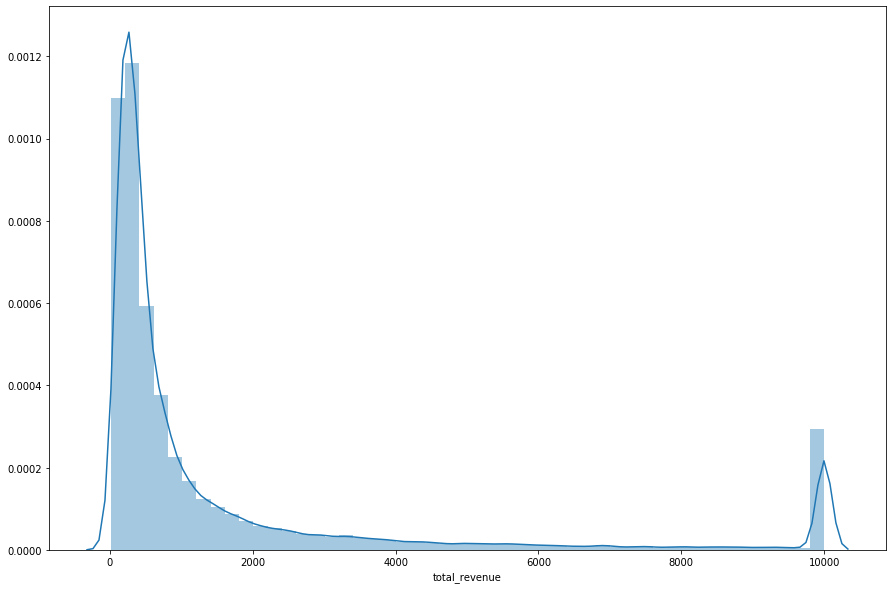

In [16]:
plt.rcParams["figure.figsize"] = (15,10)
sns.distplot(df_spine[df_spine['total_revenue']!=0]['total_revenue'].clip(upper=10000))

In [17]:
df_spine['target'] = (df_spine['total_revenue']>0).astype(int)
print("Imbalance (%):")
df_spine['target'].value_counts()/df_spine.shape[0]

Imbalance (%):


0    0.852595
1    0.147405
Name: target, dtype: float64

In [ ]:
#Training 
roc_fig,roc_ax = plt.subplots(1,1)

X_train = customers.iloc[:,:-1].values
Y_train = customers.iloc[:,-1].values

trainer = model.modelfit(trainer,X_train,Y_train,return_model=True,feature_names = customers.columns.values[:-1], roc_ax=roc_ax,balance="oversample")


print("WARNING: PREDICTING TEST SET WITH THE FOLLOWING XGB PARAMETERS")
print("XGBClassifier params: ", trainer.get_xgb_params())

#Prediction
X_test = test_customers.values
predictions_proba= trainer.predict_proba(X_test)

predictions_df = id_test_customers.to_frame("id")
predictions_df["Churn_prediction"] = pd.Series(predictions_proba[:,1]).apply(lambda x: 1 if x>0.5 else 0)
predictions_df["Churn_probability"] = pd.Series(predictions_proba[:,1])
predictions_df.to_csv("/home/sanabria/Desktop/code/case_BCG/ml_case_data/final_predictions.csv")
